In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
NFFT = 4096
# to crop output so that results do not change even though file is still growing
crop_end = np.datetime64('2023-04-01T18:00:00')
start = np.datetime64('2023-03-12T10:44:51')  # only used to figure out how much to read

# use some factor so that we surely read as much as we need
read_items = int(np.ceil(1.2 * (crop_end - start) / np.timedelta64(10, 's')))
x = np.fromfile('data/QO-100_WB_2023-03-12T10_44_51_spectrum', 'float32',
                count=read_items*NFFT).reshape(-1, NFFT)
t = np.fromfile('data/QO-100_WB_2023-03-12T10_44_51_timestamps', 'datetime64[ns]',
                count=read_items)

x = x[t <= crop_end]
t = t[:x.shape[0]]

In [3]:
fs = 20e6
f_center = 745 + 9750
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))*1e-6 + f_center
f_bin = fs / NFFT

In [4]:
bandpass_offset = 10**(56/10)
bandpass = bandpass_offset * np.polyval(
    np.load('bandpass_polynomial_calibration.npy'),
    np.fft.fftshift(np.fft.fftfreq(NFFT)))
bandpass_inv = (1 / bandpass).astype('float32')

In [5]:
x_flat = x * bandpass_inv

In [6]:
rx_noise_sel = (faxis <= 10489) | ((faxis >= 10500.5) & (np.abs(faxis - 10503.02) >= 0.03))
transponder_sel = (faxis >= 10490.5) & (faxis <= 10499.75)
transponder_floor_sel = (faxis >= 10492.5) & (faxis <= 10499.45)
beacon_sel = (faxis >= 10490.5) & (faxis <= 10492.5)

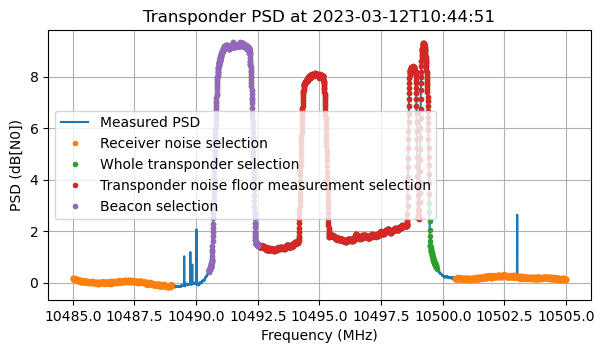

In [7]:
plt.plot(faxis, 10*np.log10(x_flat[0]))
plt.plot(faxis[rx_noise_sel], 10*np.log10(x_flat[0][rx_noise_sel]), '.')
plt.plot(faxis[transponder_sel], 10*np.log10(x_flat[0][transponder_sel]), '.')
plt.plot(faxis[transponder_floor_sel], 10*np.log10(x_flat[0][transponder_floor_sel]), '.')
plt.plot(faxis[beacon_sel], 10*np.log10(x_flat[0][beacon_sel]), '.')
plt.grid()
plt.legend([
    'Measured PSD',
    'Receiver noise selection',
    'Whole transponder selection',
    'Transponder noise floor measurement selection',
    'Beacon selection',
])
plt.ylabel('PSD (dB[N0])')
plt.xlabel('Frequency (MHz)')
plt.title(f'Transponder PSD at {str(t[0]).split(".")[0]}');

In [8]:
rx_noise = np.average(x_flat[:, rx_noise_sel], axis=1)

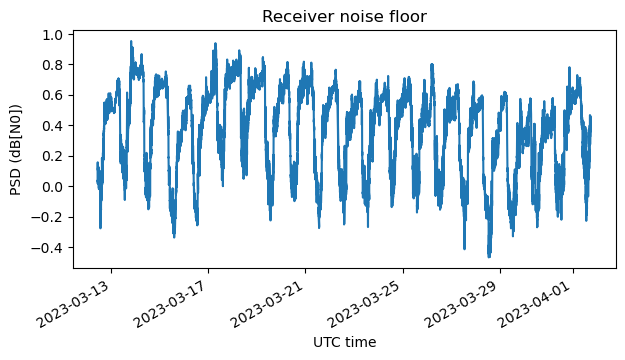

In [9]:
plt.plot(t, 10*np.log10(rx_noise))
plt.title('Receiver noise floor')
plt.ylabel('PSD (dB[N0])')
plt.xlabel('UTC time')
plt.gcf().autofmt_xdate()

In [10]:
x_cal = x_flat / rx_noise[:, np.newaxis]
del x, x_flat

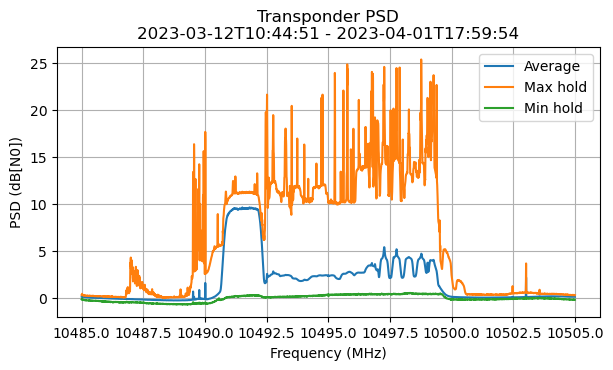

In [11]:
plt.plot(faxis, 10*np.log10(np.average(x_cal, axis=0)))
plt.plot(faxis, 10*np.log10(np.max(x_cal, axis=0)))
plt.plot(faxis, 10*np.log10(np.min(x_cal, axis=0)))
plt.grid()
plt.legend(['Average', 'Max hold', 'Min hold'])
plt.ylabel('PSD (dB[N0])')
plt.xlabel('Frequency (MHz)')
plt.title(f'Transponder PSD\n{str(t[0]).split(".")[0]} - {str(t[-1]).split(".")[0]}');

In [12]:
transponder = (np.sum(x_cal[:, transponder_sel], axis=1) - np.sum(transponder_sel)) * f_bin
beacon_plus_pedestal = (np.sum(x_cal[:, beacon_sel], axis=1) - np.sum(beacon_sel)) * f_bin
transponder_floor = (np.sum(x_cal[:, transponder_floor_sel], axis=1) - np.sum(transponder_floor_sel)) * f_bin

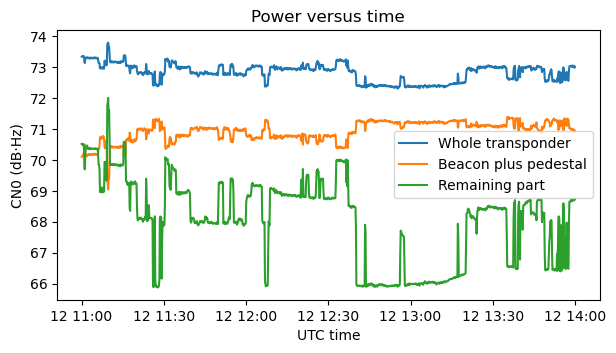

In [13]:
tsel = (t >= np.datetime64('2023-03-12T11:00:00')) & (t <= np.datetime64('2023-03-12T14:00:00'))
plt.plot(t[tsel], 10*np.log10(transponder[tsel]))
plt.plot(t[tsel], 10*np.log10(beacon_plus_pedestal[tsel]))
plt.plot(t[tsel], 10*np.log10(transponder_floor[tsel]))
plt.legend(['Whole transponder', 'Beacon plus pedestal', 'Remaining part'])
plt.ylabel('CN0 (dB·Hz)')
plt.xlabel('UTC time')
plt.title('Power versus time');

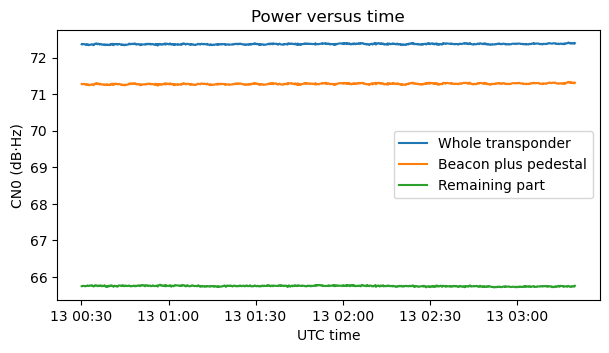

In [14]:
tsel = (t >= np.datetime64('2023-03-13T00:30:00')) & (t <= np.datetime64('2023-03-13T03:20:00'))
plt.plot(t[tsel], 10*np.log10(transponder[tsel]))
plt.plot(t[tsel], 10*np.log10(beacon_plus_pedestal[tsel]))
plt.plot(t[tsel], 10*np.log10(transponder_floor[tsel]))
plt.legend(['Whole transponder', 'Beacon plus pedestal', 'Remaining part'])
plt.ylabel('CN0 (dB·Hz)')
plt.xlabel('UTC time')
plt.title('Power versus time');

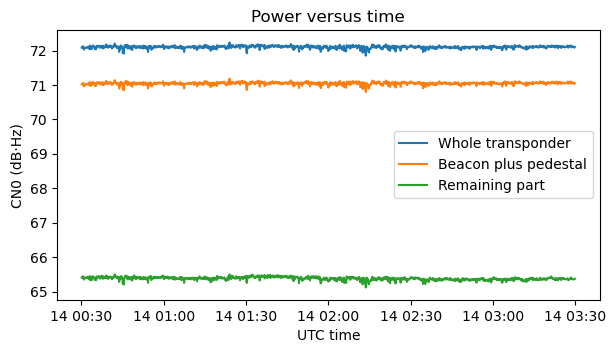

In [15]:
tsel = (t >= np.datetime64('2023-03-14T00:30:00')) & (t <= np.datetime64('2023-03-14T03:30:00'))
plt.plot(t[tsel], 10*np.log10(transponder[tsel]))
plt.plot(t[tsel], 10*np.log10(beacon_plus_pedestal[tsel]))
plt.plot(t[tsel], 10*np.log10(transponder_floor[tsel]))
plt.legend(['Whole transponder', 'Beacon plus pedestal', 'Remaining part'])
plt.ylabel('CN0 (dB·Hz)')
plt.xlabel('UTC time')
plt.title('Power versus time');

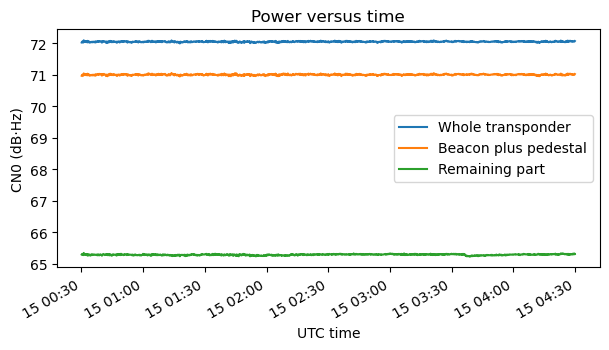

In [16]:
tsel = (t >= np.datetime64('2023-03-15T00:30:00')) & (t <= np.datetime64('2023-03-15T04:30:00'))
tsel_night_cal = tsel
plt.plot(t[tsel], 10*np.log10(transponder[tsel]))
plt.plot(t[tsel], 10*np.log10(beacon_plus_pedestal[tsel]))
plt.plot(t[tsel], 10*np.log10(transponder_floor[tsel]))
plt.legend(['Whole transponder', 'Beacon plus pedestal', 'Remaining part'])
plt.ylabel('CN0 (dB·Hz)')
plt.xlabel('UTC time')
plt.title('Power versus time')
plt.gcf().autofmt_xdate();

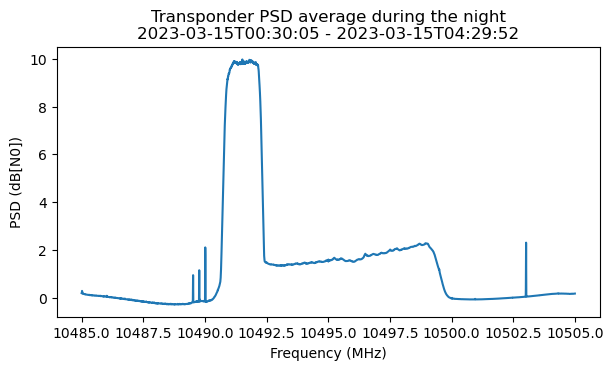

In [17]:
night_rest = np.average(x_cal[tsel_night_cal], axis=0)
plt.plot(faxis, 10*np.log10(night_rest))
plt.ylabel('PSD (dB[N0])')
plt.xlabel('Frequency (MHz)')
plt.title('Transponder PSD average during the night\n'
          f'{str(t[tsel][0]).split(".")[0]} - {str(t[tsel][-1]).split(".")[0]}');

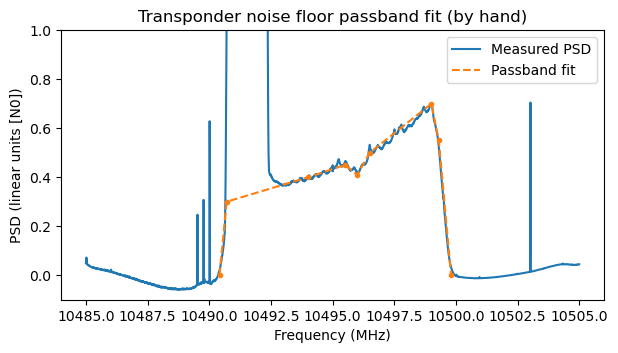

In [18]:
plt.plot(faxis, night_rest - 1)
plt.ylim(-0.1, 1)
points = [(10490.41, 0), (10490.7, 0.3), (10494, 0.4), (10495.5, 0.45), (10496, 0.41),
          (10496.5, 0.5), (10499, 0.7), (10499.3, 0.55), (10499.8, 0)]
points_x = [a[0] for a in points]
points_y = [a[1] for a in points]
plt.plot(points_x, points_y, '--')
plt.plot(points_x, points_y, '.', color='C1')
plt.ylabel('PSD (linear units [N0])')
plt.xlabel('Frequency (MHz)')
plt.title('Transponder noise floor passband fit (by hand)')
plt.legend(['Measured PSD', 'Passband fit']);

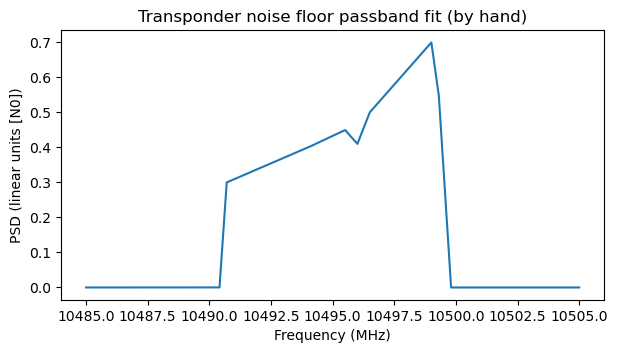

In [19]:
transponder_passband = np.interp(faxis, points_x, points_y)
transponder_passband_sel = transponder_passband != 0
plt.plot(faxis, transponder_passband)
plt.ylabel('PSD (linear units [N0])')
plt.xlabel('Frequency (MHz)')
plt.title('Transponder noise floor passband fit (by hand)');

In [20]:
transponder_whitened = ((x_cal[:, transponder_passband_sel] - 1)
                        / transponder_passband[transponder_passband_sel]).astype('float32')
transponder_whitened[transponder_whitened < 0] = 0

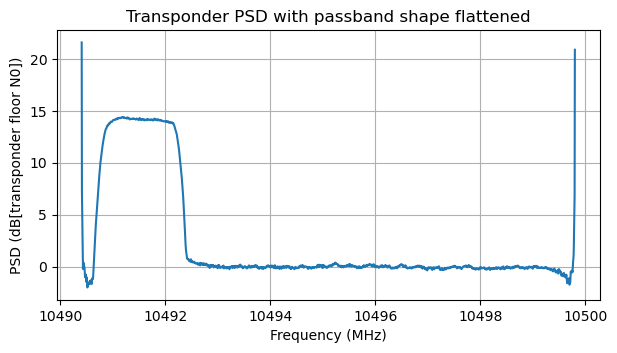

In [21]:
plt.plot(faxis[transponder_passband_sel], 10*np.log10(transponder_whitened[tsel_night_cal][0]))
plt.gca().ticklabel_format(axis='x', useOffset=False)
plt.ylabel('PSD (dB[transponder floor N0])')
plt.xlabel('Frequency (MHz)')
plt.title('Transponder PSD with passband shape flattened')
plt.grid();

In [22]:
transponder_whitened_floor = transponder_whitened[:, transponder_floor_sel[transponder_passband_sel]]

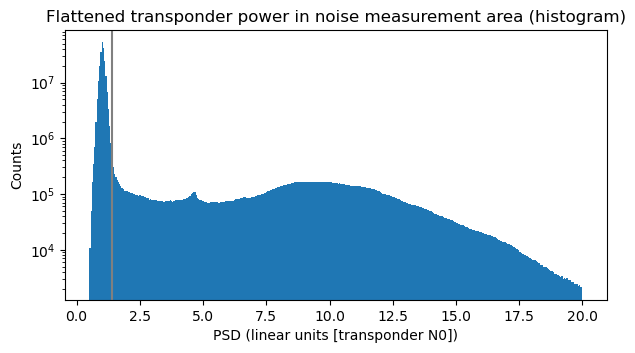

In [23]:
plt.hist(transponder_whitened_floor.ravel(), bins=np.linspace(0.5, 20, 400), log=True)
floor_threshold = 1.4
plt.axvline(x=floor_threshold, color='grey')
plt.title('Flattened transponder power in noise measurement area (histogram)')
plt.xlabel('PSD (linear units [transponder N0])')
plt.ylabel('Counts');

In [24]:
floor_sel = transponder_whitened_floor <= floor_threshold

In [25]:
floor_sel_alternative = np.zeros(transponder_whitened_floor.shape, dtype='bool')
for j in range(transponder_whitened_floor.shape[0]):
    floor_sel_alternative[j] = (
        transponder_whitened_floor[j]
        <= 1.25 * np.quantile(transponder_whitened_floor[j], 0.1))

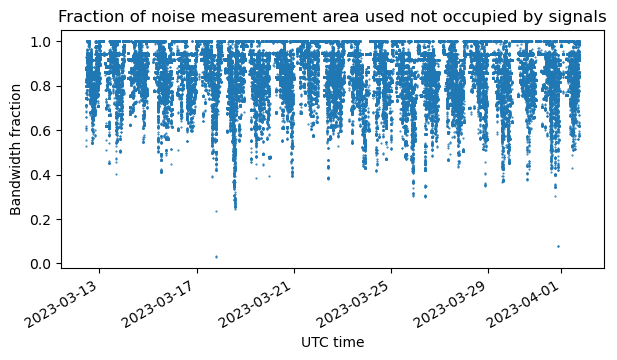

In [26]:
plt.plot(t, np.average(floor_sel, axis=1), '.', markersize=1)
plt.title('Fraction of noise measurement area used not occupied by signals')
plt.ylabel('Bandwidth fraction')
plt.xlabel('UTC time')
plt.gcf().autofmt_xdate()

In [27]:
floor_level = np.array([np.average(transponder_whitened_floor[j, floor_sel[j]])
                        for j in range(x_cal.shape[0])])
floor_level_alternative = np.array([np.average(transponder_whitened_floor[j, floor_sel_alternative[j]])
                        for j in range(x_cal.shape[0])])

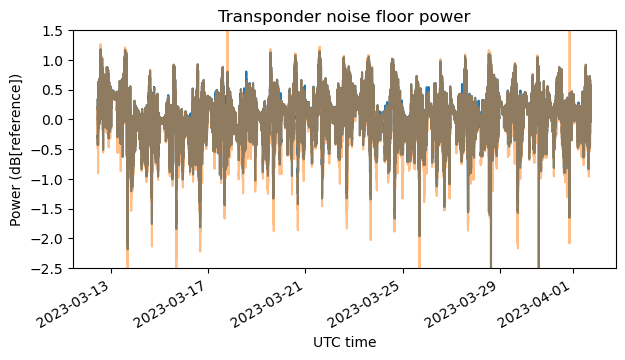

In [28]:
plt.plot(t, 10*np.log10(floor_level))
plt.plot(t, 10*np.log10(floor_level_alternative), alpha=0.5)
plt.ylim((-2.5, 1.5))
plt.title('Transponder noise floor power')
plt.ylabel('Power (dB[reference])')
plt.xlabel('UTC time')
plt.gcf().autofmt_xdate()

In [29]:
del transponder_whitened

In [30]:
beacon = (np.sum(x_cal[:, beacon_sel], axis=1) 
          - np.sum(beacon_sel)
          - floor_level * np.sum(transponder_passband[beacon_sel])) * f_bin
transponder_noise_pwr = floor_level * np.sum(transponder_passband) * f_bin
transponder_noise_pwr_alternative = floor_level_alternative * np.sum(transponder_passband) * f_bin

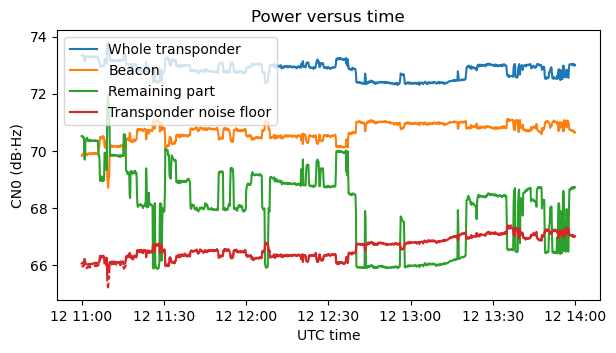

In [31]:
tsel = (t >= np.datetime64('2023-03-12T11:00:00')) & (t <= np.datetime64('2023-03-12T14:00:00'))
plt.plot(t[tsel], 10*np.log10(transponder[tsel]))
plt.plot(t[tsel], 10*np.log10(beacon[tsel]))
plt.plot(t[tsel], 10*np.log10(transponder_floor[tsel]))
plt.plot(t[tsel], 10*np.log10(transponder_noise_pwr[tsel]))
plt.plot(t[tsel], 10*np.log10(transponder_noise_pwr_alternative[tsel]), '--', color='C3')
plt.legend(['Whole transponder', 'Beacon', 'Remaining part', 'Transponder noise floor'])
plt.ylabel('CN0 (dB·Hz)')
plt.xlabel('UTC time')
plt.title('Power versus time');

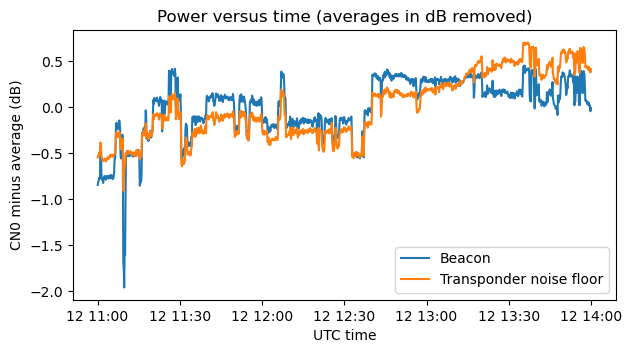

In [32]:
plt.plot(t[tsel], 10*np.log10(beacon[tsel]) - np.average(10*np.log10(beacon[tsel])))
fl = 10*np.log10(transponder_noise_pwr[tsel])
plt.plot(t[tsel], fl - np.average(fl))
plt.legend(['Beacon', 'Transponder noise floor'])
plt.ylabel('CN0 minus average (dB)')
plt.xlabel('UTC time')
plt.title('Power versus time (averages in dB removed)');

In [33]:
gain = beacon
input_pwr = transponder / gain
output_pwr = transponder
input_pwr_db = 10*np.log10(input_pwr)
output_pwr_db = 10*np.log10(output_pwr)

/tmp/ipykernel_3817/1803560009.py:4: RuntimeWarning: invalid value encountered in log10
  input_pwr_db = 10*np.log10(input_pwr)


In [34]:
selnan = ~np.isnan(input_pwr_db) & ~np.isnan(output_pwr_db)
gain_fit = np.polyfit(input_pwr_db[selnan], output_pwr_db[selnan], 2)
gain_fit

array([-6.35347340e-02,  7.70144364e-01,  7.12489709e+01])

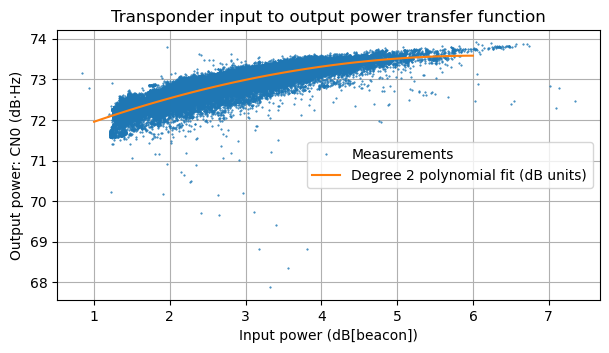

In [35]:
plt.plot(input_pwr_db, output_pwr_db, '.', markersize=1)
input_range = np.linspace(1, 6, 100)
plt.plot(input_range, np.polyval(gain_fit, input_range))
plt.grid()
plt.xlabel('Input power (dB[beacon])')
plt.ylabel('Output power: CN0 (dB·Hz)')
plt.title('Transponder input to output power transfer function')
plt.legend(['Measurements', 'Degree 2 polynomial fit (dB units)']);

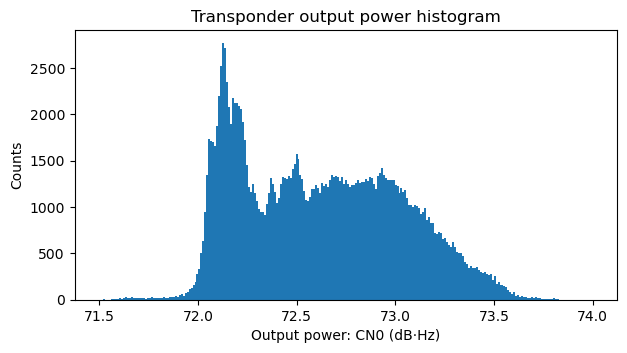

In [36]:
plt.hist(output_pwr_db, bins=np.linspace(71.5, 74, 250))
plt.title('Transponder output power histogram')
plt.xlabel('Output power: CN0 (dB·Hz)')
plt.ylabel('Counts');

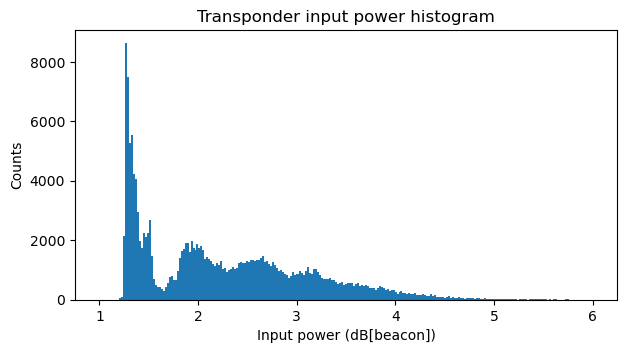

In [37]:
plt.hist(input_pwr_db, bins=np.linspace(1, 6, 250))
plt.title('Transponder input power histogram')
plt.xlabel('Input power (dB[beacon])')
plt.ylabel('Counts');

/tmp/ipykernel_3817/1683881993.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(10*np.log10(beacon), bins=np.linspace(67.5, 71.25, 250))


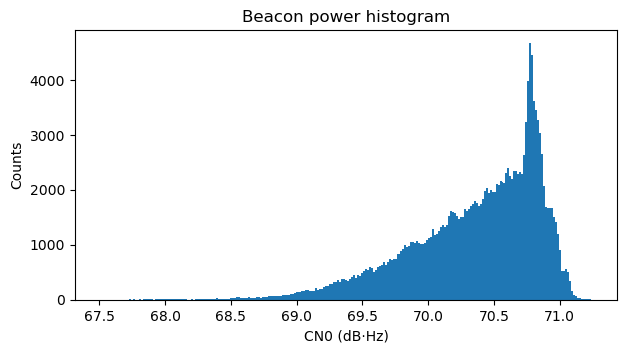

In [38]:
plt.hist(10*np.log10(beacon), bins=np.linspace(67.5, 71.25, 250))
plt.title('Beacon power histogram')
plt.xlabel('CN0 (dB·Hz)')
plt.ylabel('Counts');

In [39]:
transponder_noise_output = np.average(floor_level) * np.sum(transponder_passband) * f_bin
10*np.log10(transponder_noise_output)

66.21175351099146

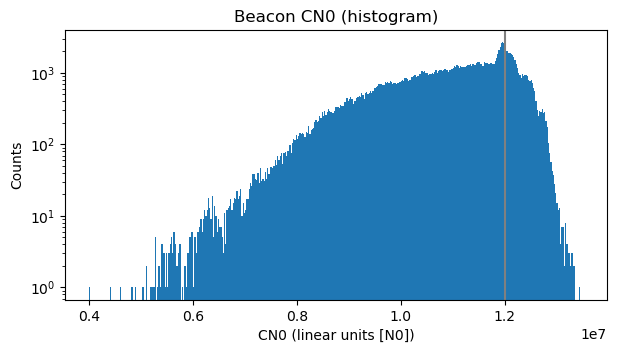

In [40]:
plt.hist(beacon, bins=np.linspace(4e6, 13.5e6, 400), log=True);
beacon_output = 12e6
plt.axvline(x=beacon_output, color='grey')
plt.title('Beacon CN0 (histogram)')
plt.xlabel('CN0 (linear units [N0])')
plt.ylabel('Counts');

In [41]:
10*np.log10(beacon_output)

70.79181246047625

In [42]:
10*np.log10(np.average(beacon[tsel_night_cal]))

70.78448295593262

In [43]:
budget_output = 10**(73/10)
budget_output_usable = budget_output - transponder_noise_output
# The factor 1 below makes the target grounstation G/T equal to my station.
# This should be scaled for other groundstations.
budget_snr = budget_output_usable / (transponder_noise_output + 1 * np.sum(transponder_sel) * f_bin)
10*np.log10(budget_output_usable), 10*np.log10(budget_snr)

(71.97904173625085, 0.6989161470791723)

In [44]:
bps_per_hz_budget_snr = np.log2(1 + budget_snr)
bps_per_hz_budget_snr

1.120752956914095

In [45]:
10*np.log10(budget_output_usable)

71.97904173625085

In [46]:
base_point_in = 10*np.log10(1 + transponder_noise_output / beacon_output)
base_point_in

1.2979703079462823

In [47]:
base_point_out = 10*np.log10(transponder_noise_output + beacon_output)
base_point_out

72.08978276842254

In [48]:
operational_point_in = 3
operational_point_out = 73
gain_reduction = (operational_point_out - base_point_out) - (operational_point_in - base_point_in)
gain_reduction

-0.7918124604762553

In [49]:
beacon_output_reduced = beacon_output * 10**(gain_reduction/10)
10*np.log10(beacon_output_reduced)

69.99999999999999

In [50]:
budget_output_besides_beacon = budget_output_usable - beacon_output_reduced
10*np.log10(budget_output_besides_beacon)

67.61373880574895

In [51]:
beacon_bw = 1.5 * 1.2
budget_besides_beacon_snr = budget_output_besides_beacon / (
    (9-beacon_bw)/9*(transponder_noise_output + 1 * np.sum(transponder_sel) * f_bin))
10*np.log10(budget_besides_beacon_snr)

-2.697286653342168

In [52]:
beacon_bw = 1.5 * 1.2
budget_besides_beacon_snr = budget_output_besides_beacon / (
    (f_bin * np.sum((1 + np.average(floor_level) * transponder_passband)[transponder_sel & ~beacon_sel])))
10*np.log10(budget_besides_beacon_snr)

-2.7121833033337257

In [53]:
bps_per_hz_budget_besides_beacon_snr = np.log2(1 + budget_besides_beacon_snr)
bps_per_hz_budget_besides_beacon_snr

0.6187342252960589

In [54]:
beacon_sel_tight = np.abs(faxis - 10491.5) <= 1.5/2
beacon_esn0 = beacon_output_reduced / 1.5e6 / (
    1 + np.average(floor_level) * np.average(transponder_passband[beacon_sel_tight]))
10*np.log10(beacon_esn0)

6.999732943020035

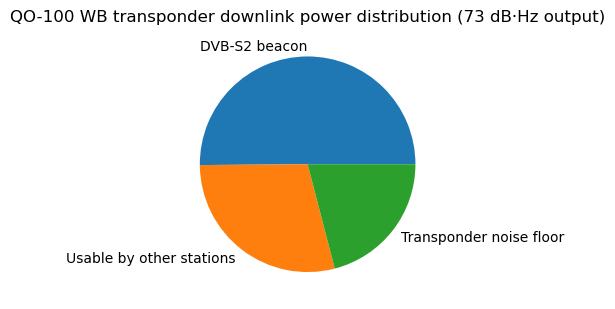

In [55]:
labels = ['DVB-S2 beacon', 'Usable by other stations', 'Transponder noise floor']
plt.pie([beacon_output_reduced, budget_output_besides_beacon, transponder_noise_output],
        labels=labels);
plt.title('QO-100 WB transponder downlink power distribution (73 dB·Hz output)');

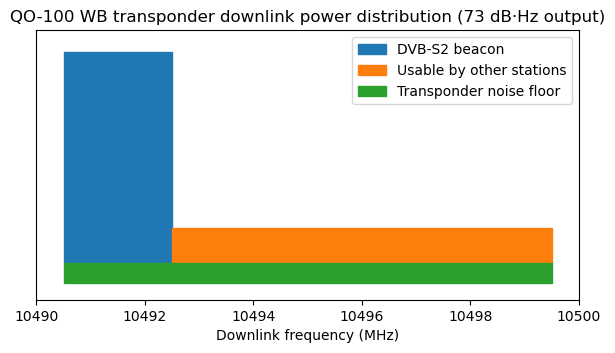

In [56]:
fig, ax = plt.subplots()
transponder_bw = 9
noise_psd = transponder_noise_output / budget_output / transponder_bw
beacon_bw = 2
other_bw = transponder_bw - beacon_bw
beacon_psd = beacon_output_reduced / budget_output / beacon_bw
other_psd = budget_output_besides_beacon / budget_output / other_bw
ax.add_patch(Rectangle((10490.5, noise_psd), beacon_bw, beacon_psd, color='C0'))
ax.add_patch(Rectangle((10490.5 + beacon_bw, noise_psd), other_bw, other_psd, color='C1'))
ax.add_patch(Rectangle((10490.5, 0), transponder_bw, noise_psd, color='C2'))
ax.set_xlim(10490, 10500)
ax.set_ylim(-0.02, 0.3)
ax.set_yticks([])
ax.ticklabel_format(axis='x', useOffset=False)
plt.legend(labels)
plt.title('QO-100 WB transponder downlink power distribution (73 dB·Hz output)')
plt.xlabel('Downlink frequency (MHz)');

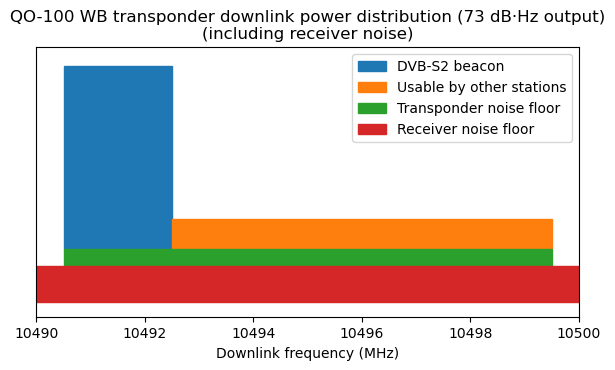

In [57]:
fig, ax = plt.subplots()
ax.add_patch(Rectangle((10490.5, noise_psd), beacon_bw, beacon_psd, color='C0'))
ax.add_patch(Rectangle((10490.5 + beacon_bw, noise_psd), other_bw, other_psd, color='C1'))
ax.add_patch(Rectangle((10490.5, 0), transponder_bw, noise_psd, color='C2'))
rx_noise_psd = 1e6 / budget_output
ax.add_patch(Rectangle((10480, -rx_noise_psd), 20, rx_noise_psd, color='C3'))
ax.set_xlim(10490, 10500)
ax.set_ylim(-0.07, 0.3)
ax.set_yticks([])
ax.ticklabel_format(axis='x', useOffset=False)
plt.legend(labels + ['Receiver noise floor'])
plt.title('QO-100 WB transponder downlink power distribution (73 dB·Hz output)\n(including receiver noise)')
plt.xlabel('Downlink frequency (MHz)');

In [58]:
t[output_pwr_db >= 73.8]

array(['2023-03-25T21:20:46.126368000', '2023-03-25T21:20:56.130932000',
       '2023-03-25T21:21:06.135671000', '2023-03-25T21:21:26.145203000',
       '2023-03-25T21:24:46.239478000', '2023-03-25T21:32:36.460643000',
       '2023-03-25T21:32:56.469976000', '2023-03-25T21:34:56.526505000',
       '2023-03-25T21:35:06.531257000', '2023-03-25T21:35:46.550008000',
       '2023-03-25T21:38:26.625464000', '2023-03-25T21:38:36.630187000',
       '2023-03-25T21:38:46.634763000', '2023-03-25T21:38:56.639549000',
       '2023-03-25T21:39:06.644198000', '2023-03-25T21:39:36.658328000',
       '2023-03-25T21:39:46.663016000', '2023-03-25T21:39:56.667814000',
       '2023-03-25T21:42:56.752417000', '2023-03-25T21:44:36.799629000',
       '2023-03-25T21:44:46.804268000', '2023-03-25T21:44:56.809044000',
       '2023-03-25T21:45:06.813669000', '2023-03-25T21:45:26.823084000',
       '2023-03-25T21:45:46.832423000', '2023-03-31T20:50:18.300618000',
       '2023-03-31T20:50:28.305301000', '2023-03-31

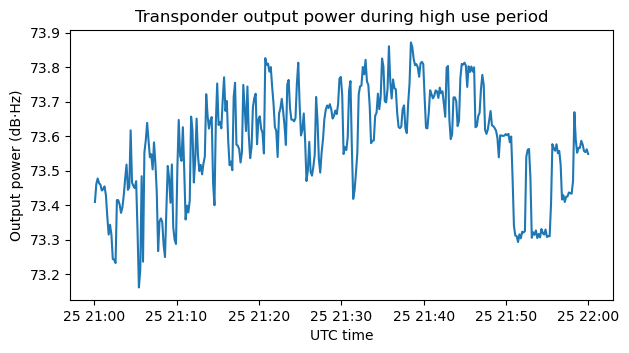

In [59]:
tsel_high_use = (t >= np.datetime64('2023-03-25T21:00')) & (t <= np.datetime64('2023-03-25T22:00'))
plt.plot(t[tsel_high_use], output_pwr_db[tsel_high_use])
plt.title('Transponder output power during high use period')
plt.xlabel('UTC time')
plt.ylabel('Output power (dB·Hz)');

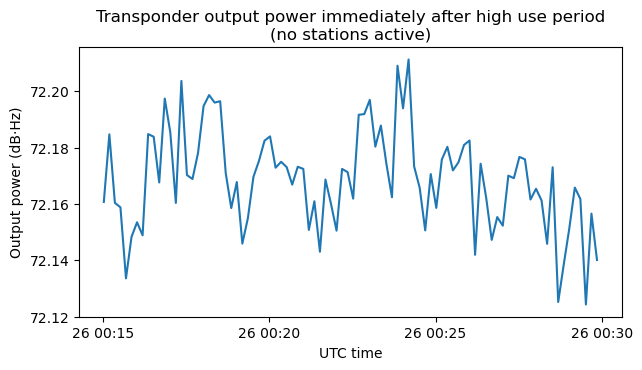

In [60]:
tsel_after_high_use = (t >= np.datetime64('2023-03-26T00:15')) & (t <= np.datetime64('2023-03-26T00:30'))
plt.plot(t[tsel_after_high_use], output_pwr_db[tsel_after_high_use])
plt.title('Transponder output power immediately after high use period\n(no stations active)')
plt.xlabel('UTC time')
plt.ylabel('Output power (dB·Hz)');

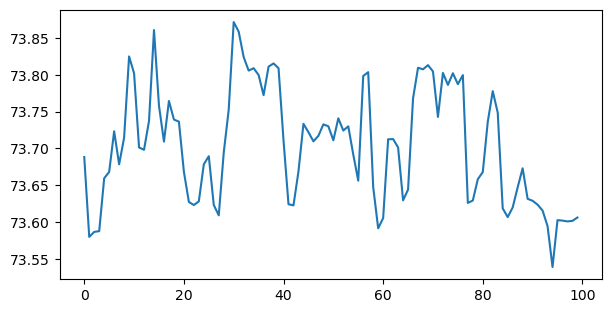

In [61]:
plt.plot(output_pwr_db[tsel_high_use][200:300])

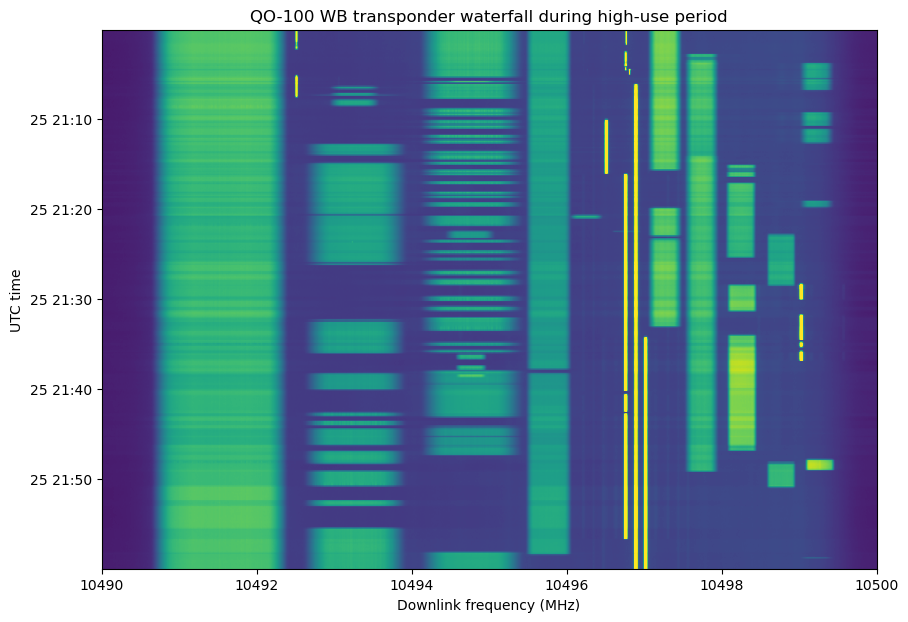

In [62]:
plt.figure(figsize=(10, 7))
fsel = (faxis >= 10490) & (faxis <= 10500)
plt.imshow(10*np.log10(x_cal[tsel_high_use][:, fsel]), aspect='auto', vmin=-1, vmax=12,
           extent=[faxis[fsel][0], faxis[fsel][-1],
                   mdates.date2num(t[tsel_high_use][-1]), mdates.date2num(t[tsel_high_use][0])])
plt.gca().yaxis_date()
plt.gca().ticklabel_format(axis='x', useOffset=False)
plt.xlabel('Downlink frequency (MHz)')
plt.ylabel('UTC time')
plt.title('QO-100 WB transponder waterfall during high-use period');

In [63]:
after_high_use_avg = np.average(x_cal[tsel_after_high_use], axis=0)

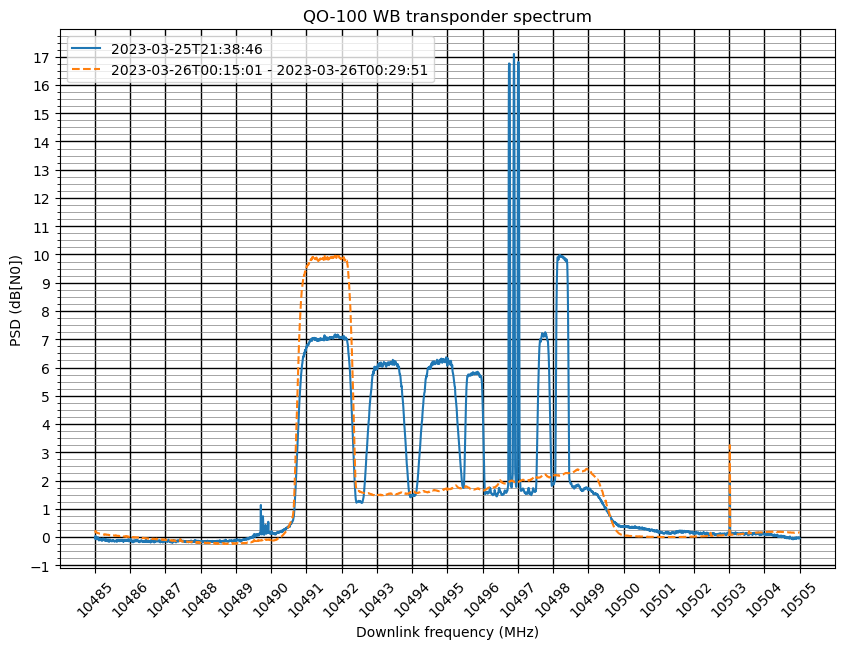

In [64]:
sel_index = 232
plt.figure(figsize=(10, 7))
plt.plot(faxis, 10*np.log10(x_cal[tsel_high_use][sel_index]))
plt.plot(faxis, 10*np.log10(after_high_use_avg), '--')
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.25))
plt.grid(linewidth=1, color='black')
plt.grid(which='minor', linewidth=0.5, color='grey')
plt.xticks(rotation=45)
plt.title('QO-100 WB transponder spectrum')
plt.xlabel('Downlink frequency (MHz)')
plt.ylabel('PSD (dB[N0])')
plt.legend([f'{str(t[tsel_high_use][sel_index]).split(".")[0]}',
            f'{str(t[tsel_after_high_use][0]).split(".")[0]} - {str(t[tsel_after_high_use][-1]).split(".")[0]}']);

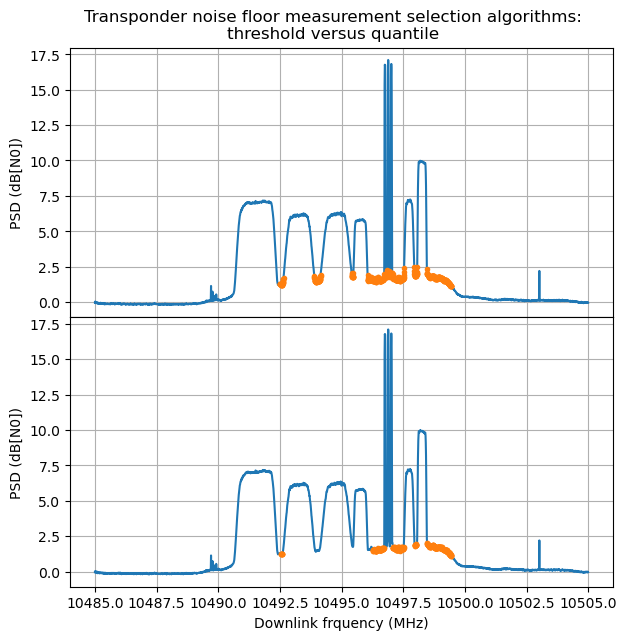

In [65]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True, sharey=True)
for ax in axs:
    ax.plot(faxis, 10*np.log10(x_cal[tsel_high_use][sel_index]))
    ax.grid()
    ax.set_ylabel('PSD (dB[N0])')
    ax.set_xlabel('Downlink frquency (MHz)')
axs[0].plot(faxis[transponder_floor_sel][floor_sel[tsel_high_use][sel_index]],
         10*np.log10(x_cal[tsel_high_use][sel_index][transponder_floor_sel][floor_sel[tsel_high_use][sel_index]]), '.')
axs[1].plot(faxis[transponder_floor_sel][floor_sel_alternative[tsel_high_use][sel_index]],
         10*np.log10(
             x_cal[tsel_high_use][sel_index][transponder_floor_sel][floor_sel_alternative[tsel_high_use][sel_index]]), '.')
plt.subplots_adjust(hspace=0)
plt.suptitle('Transponder noise floor measurement selection algorithms:\nthreshold versus quantile',
             y=0.935);

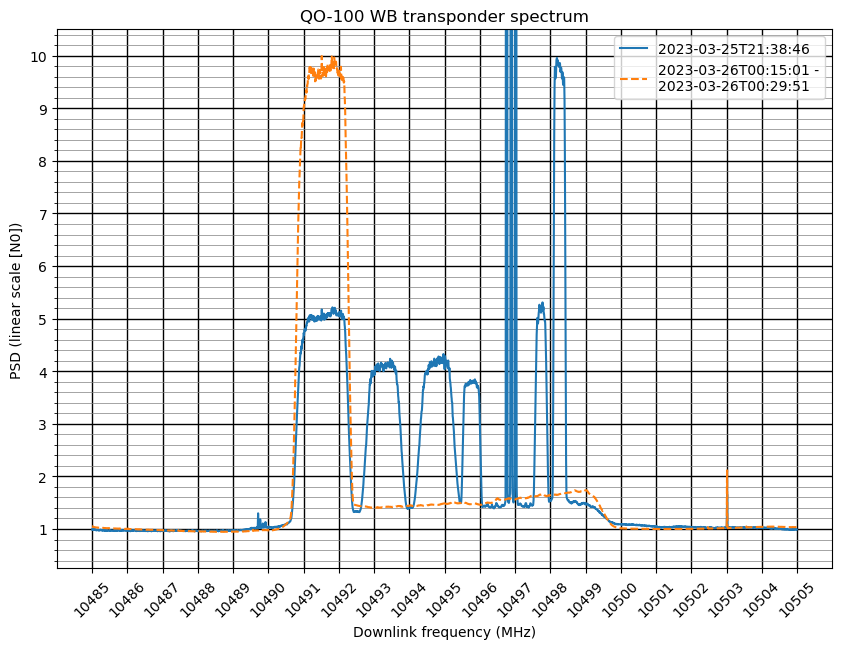

In [66]:
plt.figure(figsize=(10, 7))
plt.plot(faxis, x_cal[tsel_high_use][sel_index])
plt.plot(faxis, after_high_use_avg, '--')
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.2))
plt.grid(linewidth=1, color='black')
plt.grid(which='minor', linewidth=0.5, color='grey')
plt.xticks(rotation=45)
plt.ylim((0.25, 10.5))
plt.title('QO-100 WB transponder spectrum')
plt.xlabel('Downlink frequency (MHz)')
plt.ylabel('PSD (linear scale [N0])')
plt.legend([f'{str(t[tsel_high_use][sel_index]).split(".")[0]}',
            f'{str(t[tsel_after_high_use][0]).split(".")[0]} -\n{str(t[tsel_after_high_use][-1]).split(".")[0]}'],
           loc='upper right');

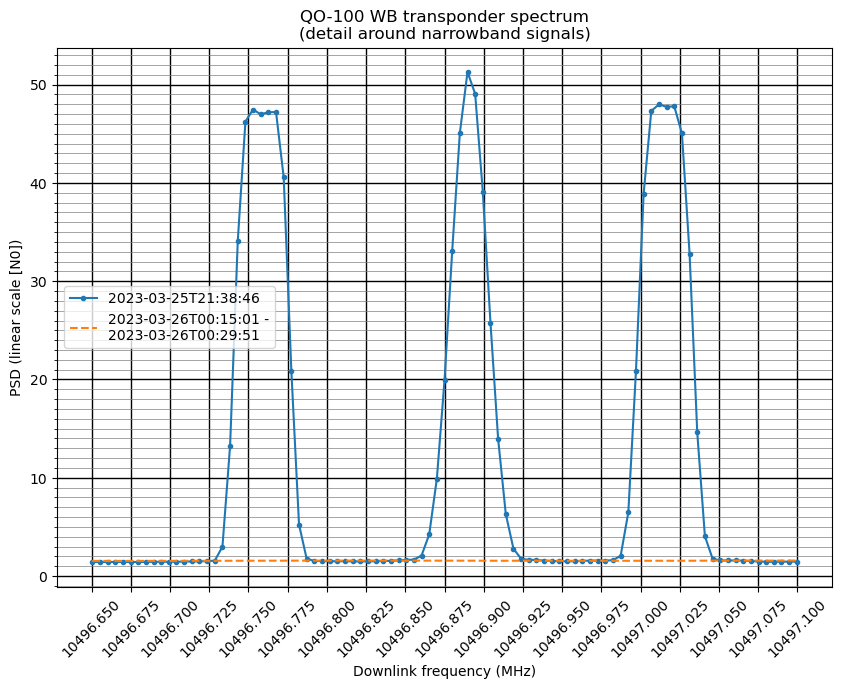

In [67]:
narrow_fsel = (faxis >= 10496.65) & (faxis <= 10497.1)
plt.figure(figsize=(10, 7))
plt.plot(faxis[narrow_fsel], x_cal[tsel_high_use][sel_index, narrow_fsel], '.-')
plt.plot(faxis[narrow_fsel], after_high_use_avg[narrow_fsel], '--')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.025))
plt.gca().ticklabel_format(axis='x', useOffset=False)
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
plt.grid(linewidth=1, color='black')
plt.grid(which='minor', linewidth=0.5, color='grey')
plt.xticks(rotation=45)
plt.title('QO-100 WB transponder spectrum\n(detail around narrowband signals)')
plt.xlabel('Downlink frequency (MHz)')
plt.ylabel('PSD (linear scale [N0])')
plt.legend([f'{str(t[tsel_high_use][sel_index]).split(".")[0]}',
            f'{str(t[tsel_after_high_use][0]).split(".")[0]} -\n{str(t[tsel_after_high_use][-1]).split(".")[0]}'],
           loc='center left');

In [68]:
beacon_eyeball = (5 - 1.3) * 1.5
others_eyeball = sum([
    (4.1 - 1.3) * 1,
    (4.2 - 1.4) * 1,
    (3.8 - 1.4) * 0.5,
    (47 - 1.4) * 0.033,
    (50 - 1.4) * 0.033,
    (48 - 1.4) * 0.033,
    (5.2 - 1.5) * 0.333,
    (9.8 - 1.5) * 0.333,
])

10*np.log10(beacon_eyeball/others_eyeball)

-4.444218145452189

In [69]:
beacon_eyeball, others_eyeball

(5.550000000000001, 15.442400000000003)

In [70]:
10*np.log10(beacon_eyeball*1e6)

67.44292983122676

In [71]:
10*np.log10(others_eyeball*1e6)

71.88714797667896

In [72]:
10*np.log10(transponder[tsel][sel_index] - (beacon_eyeball + others_eyeball)*1e6)

/tmp/ipykernel_3817/573875575.py:1: RuntimeWarning: invalid value encountered in log10
  10*np.log10(transponder[tsel][sel_index] - (beacon_eyeball + others_eyeball)*1e6)


nan

In [73]:
10*np.log10(beacon[tsel_high_use][sel_index])

67.34606266021729

In [74]:
input_pwr_db[tsel_high_use][sel_index]

6.477998

In [75]:
10*np.log10(transponder_noise_pwr[tsel_high_use][sel_index])

65.52113056182861

In [76]:
10*np.log10(transponder_noise_output)

66.21175351099146

In [77]:
10*np.log10((transponder - beacon - transponder_noise_pwr)[tsel_high_use][sel_index])

71.79798126220703

In [78]:
10*np.log10((transponder - beacon - transponder_noise_pwr_alternative)[tsel_high_use][sel_index])

71.90060138702393

In [79]:
(10*np.log10(transponder_noise_pwr[tsel_high_use][sel_index]),
 10*np.log10(transponder_noise_pwr_alternative[tsel_high_use][sel_index]))

(65.52113056182861, 65.05650997161865)

In [80]:
(10*np.log10(np.average(transponder_noise_pwr[tsel_after_high_use])),
 10*np.log10(np.average(transponder_noise_pwr_alternative[tsel_after_high_use])))

(66.49693012237549, 66.49658679962158)

In [81]:
operational_point_in_highpwr = 6.5
operational_point_out_highpwr = 73.8
gain_reduction_highpwr = ((operational_point_out_highpwr - base_point_out) 
                          - (operational_point_in_highpwr - base_point_in))
gain_reduction_highpwr

-3.4918124604762584

In [82]:
budget_output_highpwr = 10**(operational_point_out_highpwr/10)
transponder_noise_output_highpwr = 10**(65.0/10)
budget_output_usable_highpwr = budget_output_highpwr - transponder_noise_output_highpwr
# The factor 1 below makes the target grounstation G/T equal to my station.
# This should be scaled for other groundstations.
budget_snr_highpwr = (
    budget_output_usable_highpwr /
    (transponder_noise_output_highpwr + 1 * np.sum(transponder_sel) * f_bin))
10*np.log10(budget_output_usable_highpwr), 10*np.log10(budget_snr_highpwr)

(73.18606938633874, 2.2482380000461086)

In [83]:
# For a station with a 6 dB larger G/T than mine (a 2.4 m dish)
budget_snr_highpwr_largedish = (
    budget_output_usable_highpwr /
    (transponder_noise_output_highpwr + 0.25 * np.sum(transponder_sel) * f_bin))
10*np.log10(budget_snr_highpwr_largedish)

5.802791875134282

In [84]:
np.log2(1 + budget_snr_highpwr), np.log2(1 + budget_snr_highpwr_largedish)

(1.4212222431065304, 2.264337895272606)

In [85]:
beacon_output_reduced_highpwr = beacon_output * 10**(gain_reduction_highpwr/10)
10*np.log10(beacon_output_reduced_highpwr)

67.29999999999998

In [86]:
budget_output_besides_beacon_highpwr = budget_output_usable_highpwr - beacon_output_reduced_highpwr
10*np.log10(budget_output_besides_beacon_highpwr)

71.89089622550158

In [87]:
transponder_noise_reduction_highpwr = transponder_noise_output_highpwr / (np.sum(transponder_passband) * f_bin)
10*np.log10(transponder_noise_reduction_highpwr)

-1.1315394668059835

In [88]:
budget_besides_beacon_snr_highpwr = budget_output_besides_beacon_highpwr / (
    (f_bin *
     np.sum((1 + transponder_noise_reduction_highpwr * transponder_passband)[transponder_sel & ~beacon_sel])))

budget_besides_beacon_snr_highpwr_largedish = budget_output_besides_beacon_highpwr / (
    (f_bin 
     * np.sum((0.25 + transponder_noise_reduction_highpwr * transponder_passband)[transponder_sel & ~beacon_sel])))

10*np.log10(budget_besides_beacon_snr_highpwr), 10*np.log10(budget_besides_beacon_snr_highpwr_largedish)

(1.9261770303632084, 5.373734914043737)

In [89]:
np.log2(1 + budget_besides_beacon_snr_highpwr), np.log2(1 + budget_besides_beacon_snr_highpwr_largedish)

(1.3551179360012138, 2.152657848509644)

In [90]:
beacon_esn0_highpwr = beacon_output_reduced_highpwr / 1.5e6 / (
    1 + transponder_noise_reduction_highpwr * np.average(transponder_passband[beacon_sel_tight]))
beacon_esn0_highpwr_largedish = beacon_output_reduced_highpwr / 1.5e6 / (
    0.25 + transponder_noise_reduction_highpwr * np.average(transponder_passband[beacon_sel_tight]))
10*np.log10(beacon_esn0_highpwr), 10*np.log10(beacon_esn0_highpwr_largedish)

(4.570514663902293, 8.550705947531931)

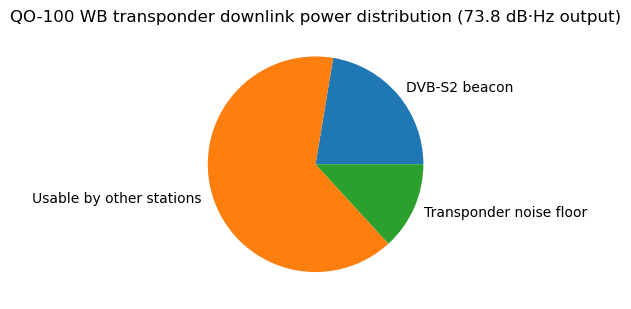

In [91]:
labels = ['DVB-S2 beacon', 'Usable by other stations', 'Transponder noise floor']
plt.pie([beacon_output_reduced_highpwr, budget_output_besides_beacon_highpwr, transponder_noise_output_highpwr],
        labels=labels);
plt.title('QO-100 WB transponder downlink power distribution (73.8 dB·Hz output)');

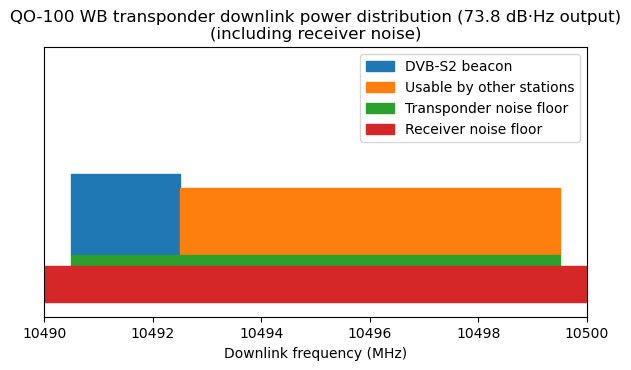

In [92]:
fig, ax = plt.subplots()
beacon_bw = 2
noise_psd_highpwr = transponder_noise_output_highpwr / budget_output_highpwr / transponder_bw
beacon_psd_highpwr = beacon_output_reduced_highpwr / budget_output_highpwr / beacon_bw
other_psd_highpwr = budget_output_besides_beacon_highpwr / budget_output_highpwr / other_bw
ax.add_patch(Rectangle((10490.5, noise_psd_highpwr), beacon_bw, beacon_psd_highpwr, color='C0'))
ax.add_patch(Rectangle((10490.5 + beacon_bw, noise_psd_highpwr), other_bw, other_psd_highpwr, color='C1'))
ax.add_patch(Rectangle((10490.5, 0), transponder_bw, noise_psd_highpwr, color='C2'))
rx_noise_psd = 1e6 / budget_output
ax.add_patch(Rectangle((10480, -rx_noise_psd), 20, rx_noise_psd, color='C3'))
ax.set_xlim(10490, 10500)
ax.set_ylim(-0.07, 0.3)
ax.set_yticks([])
ax.ticklabel_format(axis='x', useOffset=False)
plt.legend(labels + ['Receiver noise floor'])
plt.title('QO-100 WB transponder downlink power distribution (73.8 dB·Hz output)\n(including receiver noise)')
plt.xlabel('Downlink frequency (MHz)');